In [1]:
import sys
import numpy as np

from decimal import Decimal

from scipy import linalg
from scipy import integrate

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

sys.path.append('../..')
from diffnet.nn import DiffNN

In [2]:
def plot(сonditions, time):
    plt.figure(figsize=(14,5))

    x1 = сonditions[:,0]
    x2 = сonditions[:,1]
    
    plt.plot(time, x1, 'b-', label='x1')
    plt.plot(time, x2, 'r-', label='x2')

    plt.legend()
    plt.grid(True)

In [3]:
# Calculate x-vectore from z-vector 
def inv_ll(z, t):
    t_vec = np.array([1, 1]) # Set time-vector
    x  = z[0:2] # Get vectors x1_ and x2_ from z-vector
    W1 = z[2:6].reshape(-2, 2) # Get matrix W1 from z-vector
    W2 = z[6:10].reshape(-2, 2) # Get matrix W2 from z-vector

    z_ = np.matmul(A, x) + \
         np.matmul(W1, sigma(x)) + \
         np.matmul(W2, phi(x)) * u(t_vec)

    return z_

### 1.1 Define dynamical system

\begin{equation}
\begin{array}{l}
\dot{x}_{1}=-5 x_{1}+3 \operatorname{sign}\left(x_{2}\right)+u_{1} \\
\dot{x}_{2}=-10 x_{2}+2 \operatorname{sign}\left(x_{1}\right)+u_{2}
\end{array}
\end{equation}

\begin{equation}
x_{1}(0)=10, x_{2}(0)=-10
\end{equation}

In [4]:
a1 = -5.; a2 = -10.
b1 = 3.; b2 = 2.

# Initial condition of system
init_cond = np.array([10., -10.]) 
# Set time-array
time = np.linspace(0,100,1000)

# Define dynamical system with u = sin(t)
def system(x, t):
    return np.array([ a1*x[0] + b1*np.sign(x[1]) + np.sin(t),
                      a2*x[1] + b2*np.sign(x[0]) + np.sin(t)  ])

### 1.2 Define activation and rule function

Let select the neural network as $\left(\gamma\left(u_{t}\right)=u_{t}\right)$
$$
\dot{\widehat{x}}_{t}=A \widehat{x}_{t}+W_{1, t} \sigma\left(\widehat{x}_{t}\right)+W_{2, t} \phi\left(\widehat{x}_{t}\right) u_{t}
$$


and sigmoid functions are
$$
\begin{array}{l}
\sigma\left(x_{i}\right)=2 /\left(1+e^{-2 x_{i}}\right)-0.5 \\
\phi\left(x_{i}\right)=0.2 /\left(1+e^{-0.2 x_{i}}\right)-0.05
\end{array}
$$

In [5]:
# TODO: CHECK sigma-function with 2 after ()
# Define activation function sigma
def sigma(x):
    return 2 / (1 + np.exp(-2.*x)) - 0.5

# Define activation function phi
def phi(x):
    return 0.2 / (1 + np.exp(-0.2*x)) - 0.05

# Define input function u
def u(t):
    return np.sin(t)

### 1.3 Set variables and solve Riccati matrix equation


the matrix Riccati

\begin{equation}
A^{T} P+P A+P R P+Q=0
\end{equation}

from page 79

\begin{equation}
A=\left[\begin{array}{rr}
-15 & 0 \\
0 & -10
\end{array}\right]

R=\left[\begin{array}{ll}
8 & 2 \\
2 & 8
\end{array}\right]

Q=\left[\begin{array}{ll}
2 & 1 \\
1 & 2
\end{array}\right]

Q_{0}=I

\end{equation}



In [6]:
A = np.array([[-15, 0],
              [0, -10]])

R = np.array([[8, 2],
              [2, 8]])

R_inv = linalg.inv(R)

Q = np.array([[2, 1],
              [1, 2]])

Q_0 = np.diag([1, 1])

B = np.ones(4).reshape(-2, 2)

Dead-zone function $s_{t}$ is defined as
$$
\begin{array}{l}
s_{t}:=\left[1-\frac{\mu}{\left\|P^{1 / 2} \Delta\right\|}\right]_{+},[z]_{+}=\left\{\begin{array}{ll}
z & z \geq 0 \\
0 & z<0
\end{array}\right. \\
\mu=\left(\bar{\eta}_{\sigma}+\bar{\eta}_{\phi} \bar{u}\right) / \lambda_{\min }\left(P^{-1 / 2} Q_0 P^{-1 / 2}\right)
\end{array}
$$

\begin{equation}
\|P\|=\left[\sum_{i, j} a b s\left(a_{i, j}\right)^{2}\right]^{1 / 2}
\end{equation}

\begin{equation}
\bar{u}=1, \quad \bar{\eta}_{\phi}=\bar{\eta}_{\sigma}=2, \quad K_{1}=K_{2}=10 I
\end{equation}

In [7]:
def calc_nu(Q_0: np.array, P: np.array, eta_sigma: float, eta_phi: float, eta_u: float) -> float:

    P_sqr = np.sqrt(P)
    P_sqr_inv = np.linalg.inv(P_sqr)  # P^(-1/2)


    tmp_matrix = np.matmul(np.matmul(P_sqr_inv, Q_0), P_sqr_inv) # P^(-1/2)*Q_0*P^(-1/2)
    lambda_min = np.min(linalg.eigvals(tmp_matrix)).real # min eigvals of matrix P
    
    nu = (eta_sigma + eta_phi*eta_u) / lambda_min
    #return 1
    return nu

def sign_plus(z: float) -> float:
    if z >= 0:
        return z
    else:
        return 0

def s(P: np.array, delta: float, nu: float) -> float:

    P_sqr = np.sqrt(P.astype(np.complex))
    norm_value = linalg.norm(np.matmul(P_sqr, delta)) # find Frobenius matrix norm
    z_value = 1 - nu/norm_value # find z by formula 

    z_value = sign_plus(z_value) # apply sign_plus function 

    #print(z_value)
    return z_value

In [8]:
eta_u = 1; eta_phi = 2; eta_sigma = 2
K1 = K2 = 1000*np.diag([1, 1])

# Solve Riccati eq 
# Inversing of R do not touch the final colution 
P = linalg.solve_continuous_are(A, B, Q, R)

# Calculate nu-value of system
nu = calc_nu(Q_0, P, eta_sigma, eta_phi, eta_u) 

print(nu)
#print('\n',P,'\n\n',W1,'\n\n',W2)

0.955596960365192


### 1.4 Define differential equations of weights matrices

\begin{equation}
\begin{array}{c}
\dot{W}_{1, t}=-s_{t} K_{1} P \Delta_{t} \sigma\left(\widehat{x}_{t}\right)^{T} \\
\dot{W}_{2, t}=-s_{t} K_{2} P \Delta_{t} u_{t}^{T} \phi\left(\widehat{x}_{t}\right)^{T}
\end{array}
\end{equation}

\begin{equation}
W_{1,0}=\left[\begin{array}{cc}
1 & 10 \\
10 & 1
\end{array}\right] W_{2,0}=\left[\begin{array}{cc}
.1 & 0 \\
0 & .1
\end{array}\right]
\end{equation}


$s_{t}$ hase been already defined

In [9]:
# Set initial weights matrix W1
W1 = np.array([[1., 10.],
               [10., 1.]])

# Set initial weights matrix W2
W2 = np.array([[0.1, 0.],
               [0., 0.1]])

def W1_(delta, x, t):
    v1 = np.matmul(K1, P) # square matrix 
    #print(v1, delta, x)
    v2 = np.matmul(v1, delta) # vector 
    #v3 = np.matmul(sigma(x).reshape(-1, 1), v2.reshape(1,-1))
    v3 = np.matmul(v2.reshape(-1, 1), sigma(x).reshape(1, -1))

    return v3

def W2_(delta, x, t):
    t_vec = np.array([1, 1]) # Set time-vector

    v1 = np.matmul(K2, P)
    v2 = np.matmul(v1, delta)
    v3 = np.matmul(v2.reshape(-1, 1), phi(x).reshape(1, -1)) * u(t_vec) 
    
    return v3

### 1.5 Define naive identificar's equation 


Let select the neural network as $\left(\gamma\left(u_{t}\right)=u_{t}\right)$
$$
\dot{\widehat{x}}_{t}=A \widehat{x}_{t}+W_{1, t} \sigma\left(\widehat{x}_{t}\right)+W_{2, t} \phi\left(\widehat{x}_{t}\right) u_{t}
$$

In [10]:
def ident(x, t):
    t_vec = np.array([t, t]) # Create time vectore
    #x  = z[0:2]
    W1 = z0[2:6].reshape(-2, 2) # Get matrix W1 from z-vectore
    W2 = z0[6:10].reshape(-2, 2) # Get matrix W2 from z-vectore
    
    x_ = np.matmul(A, x) + \
         np.matmul(W1, sigma(x)) + \
         np.matmul(W2, phi(x)) * u(t_vec)

    return x_

### 2.1 Calculate delta for first step with naive identificar

Initial state of identificar:
\begin{equation}
\widehat{x}_{0}=[-5,-5]^{T}
\end{equation}


Define delta:
\begin{equation}
\Delta_{t}:=\widehat{x}_{t}-x_{t}
\end{equation}

In [11]:
init_cond_x_ = np.array([-5., -5.]) 
# Initial state of identificar
z0 = np.concatenate((init_cond_x_, W1.flatten(), W2.flatten())) 

# Get states of system 
states_system, states_system_info = integrate.odeint(system, init_cond, time,  full_output=True)

# Get states of ident system
states_ident, states_ident_info = integrate.odeint(ident, np.array([-5, -5]), time,  full_output=True)

# Calculate delta vectore of states x and x_
delta = states_ident - states_system
#delta = (states_ident - states_system)

print(delta)

[[-15.           5.        ]
 [ -7.2223107    1.38332053]
 [ -3.80571159   0.26170599]
 ...
 [  0.56508939   1.27655334]
 [  0.55260236   1.26954141]
 [  0.53867207   1.26187063]]


In [12]:
# Separate delta-vector in delta-vectors for x1 and x2
delta_1, delta_2 = delta.T

# Update delta values 
delta_1_value = interp1d(time, delta_1, fill_value='extrapolate') 
delta_2_value = interp1d(time, delta_2, fill_value='extrapolate')

### 2.2 Define learning law

Will solve the following system of differential equations:

$$
\dot{\widehat{x}}_{t}=A \widehat{x}_{t}+W_{1, t} \sigma\left(\widehat{x}_{t}\right)+W_{2, t} \phi\left(\widehat{x}_{t}\right) u_{t}
$$

\begin{equation}
\begin{array}{c}
\dot{W}_{1, t}=-s_{t} K_{1} P \Delta_{t} \sigma\left(\hat{x}_{t}\right)^{T} \\
\dot{W}_{2, t}=-s_{t} K_{2} P \Delta_{t} u_{t}^{T} \phi\left(\hat{x}_{t}\right)^{T}
\end{array}
\end{equation}

with initial state:

$$ z_0 = [\widehat{x}_{0}, W_{1,0}, W_{2,0}]=[-5, -5, 1, 10, 10, 1, 0.1, 0, 0, 0.1]$$


\begin{equation}
\widehat{x}_{0}=[-5,-5]^{T}
\end{equation}
\begin{equation}
W_{1,0}=\left[\begin{array}{cc}
1 & 10 \\
10 & 1
\end{array}\right] W_{2,0}=\left[\begin{array}{cc}
.1 & 0 \\
0 & .1
\end{array}\right]
\end{equation}

In [13]:
# Implementation of learning law, calculate z-vectore like colution of ODE-system
def ll(z, t):
    
    d1 = delta_1_value(t) # Get delta of x1 for t-step
    d2 = delta_2_value(t) # Get delta of x2 for t-step
    delta = np.array([d1, d2]) # Create delta-vector for t-step

    t_vec = np.array([t, t]) # Set time-vector
    x  = z[0:2] # Get vectors x1_ and x2_ from z-vector
    W1 = z[2:6].reshape(-2, 2) # Get matrix W1 from z-vector
    W2 = z[6:10].reshape(-2, 2) # Get matrix W2 from z-vector

    z0 = np.matmul(A, x) + \
         np.matmul(W1, sigma(x)) + \
         np.matmul(np.matmul(W2, phi(x)), u(t_vec)) # [z_01, z_02]

    # TODO: update W1 and W2  
    z1 = -1 * s(P, delta, nu) * W1_(delta, x, t_vec) # [[z_11, z_12], [z_13, z_14]] 
    #z1 = -1 * W1_(delta, x, t_vec) #

    z2 = -1 * s(P, delta, nu) * W2_(delta, x, t_vec) # [[z_21, z_22], [z_23, z_24]]
    #z2 = -1 * W2_(delta, x, t_vec) 
    #print(s(P, delta, nu))
    return np.concatenate((z0, z1, z2), axis=None)

### 2.3 Calculate second step with learning law

In [14]:
#states_ll, states_ident_info = integrate.odeint(ll, z0, time,  full_output=True)

#print(states_ll[0])

In [15]:
# Map z-values to x-values for second step
#x_ll_states = np.empty_like(states_system)
#for j in range(1000):
#    t = time[j]
#    z = states_ll[j]
#
#    x_ll_states[j] = inv_ll(z, t)

### 2.4 Start learning process by LL

In [16]:
epochs = 3
n = time.shape[0]
#MSE = np.sqrt(np.sum((x_ll_states - states_system)*(x_ll_states - states_system))/n)
z_next = z0 
x_ll_epochs = {}
#x_ll_epochs[-1] = x_ll_states

#print('Epoch {0}, MSE: {1}'.format(-1, MSE))

for i in range(epochs):
    # Set MSE from previous iteration-step
    #prev_MSE = MSE

    # Calculate states of identificator of current iteration-step
    states_ll, states_ident_info = integrate.odeint(ll, z0, time,  full_output=True)  # ??? reset z0 in each iteration ??? 

    # Defina empty vector to save states of identificator 
    x_ll_states = np.empty_like(states_ident)

    # Calculates x-vector from z-vector of identificator's states
    for j in range(1000):
        t = time[j]
        z = states_ll[j]

        x_ll_states[j] = inv_ll(z, t)

    # Save x_ll_states of current epoch
    x_ll_epochs[i] = x_ll_states

    # Calculate MSE and delta of current iteration-step
    delta = states_ident - states_system
    MSE = np.sqrt(np.sum((x_ll_states - states_system)*(x_ll_states - states_system))/n)

    # Separate delta-vector in delta-vectors for x1 and x2
    delta_1, delta_2 = delta.T

    # Update delta values 
    delta_1_value = interp1d(time, delta_1, fill_value='extrapolate')
    delta_2_value = interp1d(time, delta_2, fill_value='extrapolate')

    print('Epoch {0}, MSE: {1}'.format(i, MSE) )

    # Early stop condition
    #if abs(prev_MSE - MSE) < 1.23E-10:
    #    break
    
    # ??? Update ??? z0 in each iteration ??? 
    z_next = states_ll[0]
    print('Mean of z-values in step: {0}'.format(np.mean(states_ll)))

Epoch 0, MSE: 2.7833009590538063
Mean of z-values in step: -2.221278058244189
Epoch 1, MSE: 2.7833009590538063
Mean of z-values in step: -2.221278058244189
Epoch 2, MSE: 2.7833009590538063
Mean of z-values in step: -2.221278058244189


In [17]:
MSE

2.7833009590538063

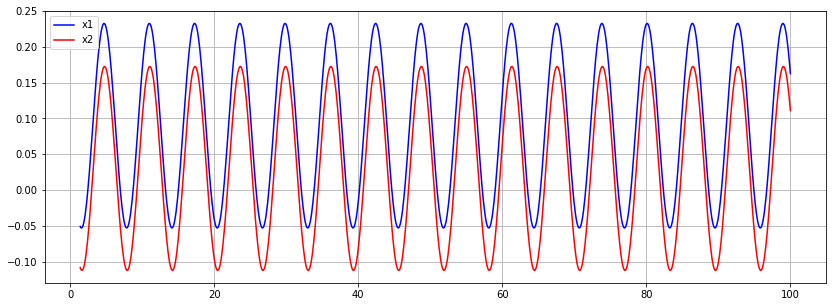

In [18]:
plot(x_ll_states[14:], time[14:])

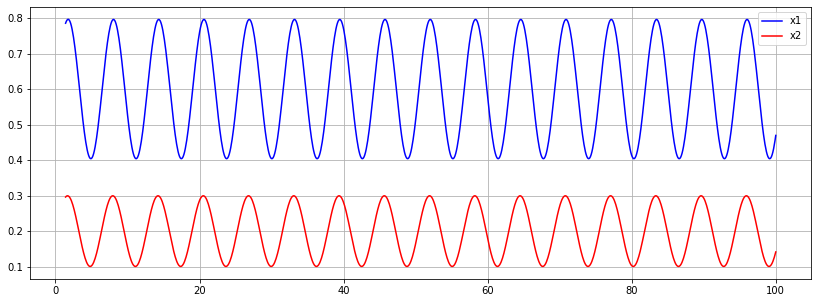

In [19]:
plot(states_system[14:], time[14:])

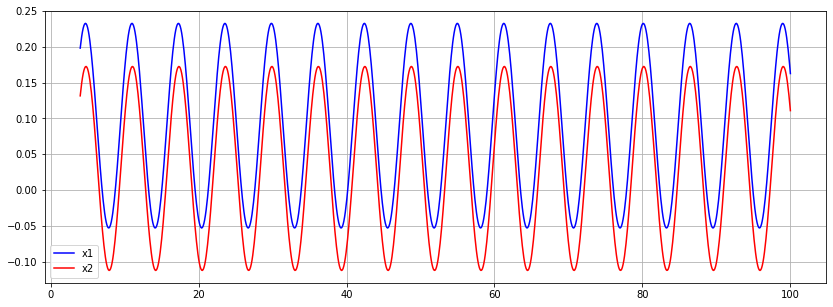

In [20]:
plot(x_ll_epochs[0][40:], time[40:])


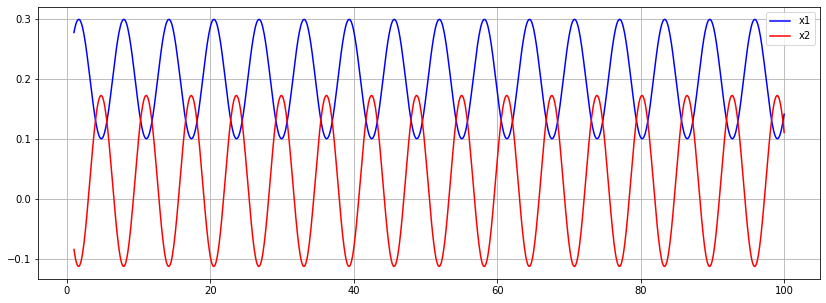

In [21]:
plt.figure(figsize=(14,5))


sys_x1 = states_system[:,0]
sys_x2 = states_system[:,1]

ind_x1 = x_ll_states[:,0]
ind_x2 = x_ll_states[:,1]

plt.plot(time[10:], sys_x2[10:], 'b-', label='x1')
plt.plot(time[10:], ind_x2[10:], 'r-', label='x2')

plt.legend()
plt.grid(True)